# Batch Normalization

**Objective:** The objective of this assignment is to evaluate students' comprehension of batch normalization in artificial neural networks (ANN) and its impact on training performance. The assignment is divided into three main sections: Concepts, Implementation, and Experimentation and Analysis.
1. Theory and Concepts:
    1. Explain the concept of batch normalization in the context of Artificial Neural Networks.
    2. Describe the benefits of using batch normalization during training.
    3. Discuss the working principle of batch normalization, including the normalization step and the learnable parameters.
2. Implementation:
    1. Choose a dataset of your choice (e.g., MNIST, CIFAR-10) and preprocess it.
    2. Implement a simple feedforward neural network using any deep learning framework/library (e.g., TensorFlow, PyTorch).
    3. Train the neural network on the chosen dataset without using batch normalization.
    4. Implement batch normalization layers in the neural network and train the model again.
    5. Compare the training and validation performance (e.g., accuracy, loss) between the models with and without batch normalization.
    6. Discuss the impact of batch normalization on the training process and the performance of the neural network.
3. Experimentation and Analysis:
    1. Experiment with different batch sizes and observe the effect on the training dynamics and model performance.
    2. Discuss the advantages and potential limitations of batch normalization in improving the training of neural networks.

#### Theory and Concepts:
1. Explain the concept of batch normalization in the context of Artificial Neural Networks.
    1. Concept of Batch Normalization: Batch normalization (BatchNorm) is a technique used in Artificial Neural Networks to improve the stability and speed of training. It normalizes the activations of a neural network layer by adjusting and scaling them during each mini-batch of training data. This ensures that the inputs to each layer have a consistent mean and variance, which helps in mitigating issues like vanishing/exploding gradients and allows for faster convergence.
2. Describe the benefits of using batch normalization during training.
    2. Benefits of Batch Normalization:
        * **Improved Training Stability:** BatchNorm reduces internal covariate shift by normalizing activations, making it easier to train deeper networks.
        * **Faster Convergence:** It accelerates training by reducing the number of training epochs required to reach a good solution.
        * **Regularization:** BatchNorm acts as a form of regularization, reducing the need for other regularization techniques like dropout.
        * **Ability to Use Higher Learning Rates:** It allows for the use of higher learning rates without causing instability.
3. Discuss the working principle of batch normalization, including the normalization step and the learnable parameters.
    3. Working Principle of Batch Normalization:
        * **Normalization Step:** For each mini-batch, BatchNorm computes the mean and variance of the activations within that batch. It then normalizes the activations using these batch-specific statistics, effectively centering and scaling the values.
        * **Learnable Parameters:** BatchNorm introduces two learnable parameters, gamma (γ) and beta (β), for each feature in the layer. These parameters allow the network to adaptively adjust the normalized values. γ scales the normalized values, and β shifts them.

### Using Pytorch

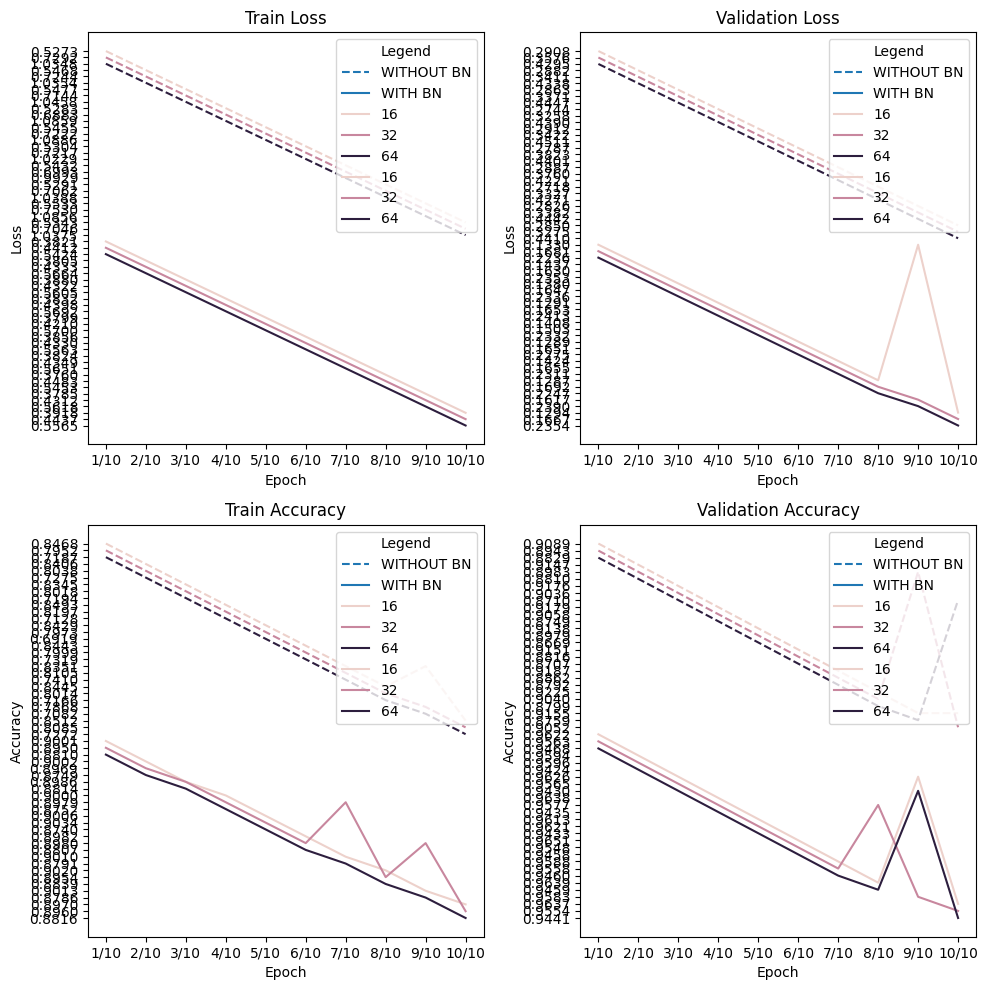

,Epoch,Batch Size,Train Loss (WITHOUT BN),Train Loss (WITH BN),Validation Loss (WITHOUT BN),Validation Loss (WITH BN),Train Accuracy (WITHOUT BN),Train Accuracy (WITH BN),Validation Accuracy (WITHOUT BN),Validation Accuracy (WITH BN)
0,1/10,16,0.5273,0.3821,0.2908,0.1330,0.8468,0.9001,0.9089,0.9622
1,1/10,32,0.7292,0.4412,0.3576,0.1681,0.7952,0.8950,0.8943,0.9563
2,1/10,64,1.0348,0.5424,0.4295,0.2236,0.7187,0.8810,0.8829,0.9468
3,2/10,16,0.5468,0.3805,0.2882,0.1437,0.8406,0.9002,0.9147,0.9594
4,2/10,32,0.7244,0.4333,0.3411,0.1630,0.8038,0.8969,0.8983,0.9596


In [1]:
import torch
import pandas            as pd
import seaborn           as sb
import torch.nn          as nn
import torch.optim       as opt
import matplotlib.pyplot as pt
from matplotlib.lines import Line2D
from torchvision      import datasets, transforms
from torch.utils.data import DataLoader

# Loading Datasets
def load_data(batch_size=64):
    transform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
    train_data = datasets.MNIST(root='./data', train=True , transform=transform, download=True)
    test_data  = datasets.MNIST(root='./data', train=False, transform=transform)
    train      = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test       = DataLoader(test_data , batch_size=batch_size, shuffle=False)
    return train, test

# Define a simple FeedForward neural network WITHOUT Batch Normalization
class ModelWithoutBN(nn.Module):
    def __init__(self):
        super(ModelWithoutBN, self).__init__()
        self.fc1 = nn.Linear(784,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Define a simple FeedForward neural network WITH Batch Normalization
class ModelWithBN(nn.Module):
    def __init__(self):
        super(ModelWithBN, self).__init__()
        self.fc1 = nn.Linear(784,128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64,10)
    def forward(self,x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# Training Function
def Train(model, train, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct      = 0
    for d, t in train:
        d, t          = d.to(device), t.to(device)
        optimizer.zero_grad()
        op            = model(d.view(-1,784))
        loss          = criterion(op,t)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, pred       = torch.max(op, 1)
        correct      += (pred == t).sum().item()
    return running_loss/len(train), correct/len(train.dataset)

# Validation Function
def validate(model, test, criterion, device):
    model.eval()
    running_loss = 0
    correct      = 0
    with torch.no_grad():
        for d, t in test:
            d, t          = d.to(device), t.to(device)
            op            = model(d.view(-1,784))
            loss          = criterion(op,t)
            running_loss += loss.item()
            _, pred       = torch.max(op, 1)
            correct      += (pred == t).sum().item()
    return running_loss/len(test), correct/len(test.dataset)

# Main
batch_sizes = [16, 32, 64]
lr          = 0.01
epochs      = 10
results     = []

for e in range(epochs):
    rows = []
    for bs in batch_sizes:
        train, test = load_data(bs)
        device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        criterion   = nn.CrossEntropyLoss()
        
        m1 = ModelWithoutBN().to(device)
        m2 = ModelWithBN().to(device)
        opt1 = opt.SGD(m1.parameters(), lr=lr)
        opt2 = opt.SGD(m2.parameters(), lr=lr)
        
        train_loss1, train_acc1 = Train    (m1, train, opt1, criterion, device)
        val_loss1  , val_acc1   = validate (m1, test       , criterion, device)
        train_loss2, train_acc2 = Train    (m2, train, opt2, criterion, device)
        val_loss2  , val_acc2   = validate (m2, test       , criterion, device)
        
        row = [f"{e+1}/{epochs}"   , bs,
               f"{train_loss1:.4f}", f"{train_loss2:.4f}",
               f"{val_loss1  :.4f}", f"{val_loss2  :.4f}",
               f"{train_acc1 :.4f}", f"{train_acc2 :.4f}", 
               f"{val_acc1   :.4f}", f"{val_acc2   :.4f}"]
        rows.append(row)
    results.extend(rows)
    
# Creating a DataFrame
header = ["Epoch"                           ,"Batch Size",
          "Train Loss (WITHOUT BN)"         , "Train Loss (WITH BN)",
          "Validation Loss (WITHOUT BN)"    , "Validation Loss (WITH BN)",
          "Train Accuracy (WITHOUT BN)"     , "Train Accuracy (WITH BN)",
          "Validation Accuracy (WITHOUT BN)", "Validation Accuracy (WITH BN)"]
df = pd.DataFrame(results, columns= header)

# For Visualizing the DataFrame
fig, ax = pt.subplots(2, 2, figsize=(10, 10))
sb.lineplot(data=df, x='Epoch', y='Train Loss (WITHOUT BN)'         , hue='Batch Size', ax=ax[0,0], linestyle='--')
sb.lineplot(data=df, x='Epoch', y='Train Loss (WITH BN)'            , hue='Batch Size', ax=ax[0,0])
sb.lineplot(data=df, x='Epoch', y='Validation Loss (WITHOUT BN)'    , hue='Batch Size', ax=ax[0,1], linestyle='--')
sb.lineplot(data=df, x='Epoch', y='Validation Loss (WITH BN)'       , hue='Batch Size', ax=ax[0,1])
sb.lineplot(data=df, x='Epoch', y='Train Accuracy (WITHOUT BN)'     , hue='Batch Size', ax=ax[1,0], linestyle='--')
sb.lineplot(data=df, x='Epoch', y='Train Accuracy (WITH BN)'        , hue='Batch Size', ax=ax[1,0])
sb.lineplot(data=df, x='Epoch', y='Validation Accuracy (WITHOUT BN)', hue='Batch Size', ax=ax[1,1], linestyle='--')
sb.lineplot(data=df, x='Epoch', y='Validation Accuracy (WITH BN)'   , hue='Batch Size', ax=ax[1,1])

ax[0,0].set(title='Train Loss'         , xlabel='Epoch', ylabel='Loss')
ax[0,1].set(title='Validation Loss'    , xlabel='Epoch', ylabel='Loss')
ax[1,0].set(title='Train Accuracy'     , xlabel='Epoch', ylabel='Accuracy')
ax[1,1].set(title='Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')

ls = [Line2D([0],[0], linestyle='--', label='WITHOUT BN'), Line2D([0],[0], linestyle='-', label='WITH BN')] 
ax[0,0].legend(handles=ls + ax[0,0].get_legend().legendHandles, title='Legend')
ax[0,1].legend(handles=ls + ax[0,1].get_legend().legendHandles, title='Legend')
ax[1,0].legend(handles=ls + ax[1,0].get_legend().legendHandles, title='Legend')
ax[1,1].legend(handles=ls + ax[1,1].get_legend().legendHandles, title='Legend')

pt.tight_layout()
pt.show()
df.head()

### Using Tensorflow and Keras

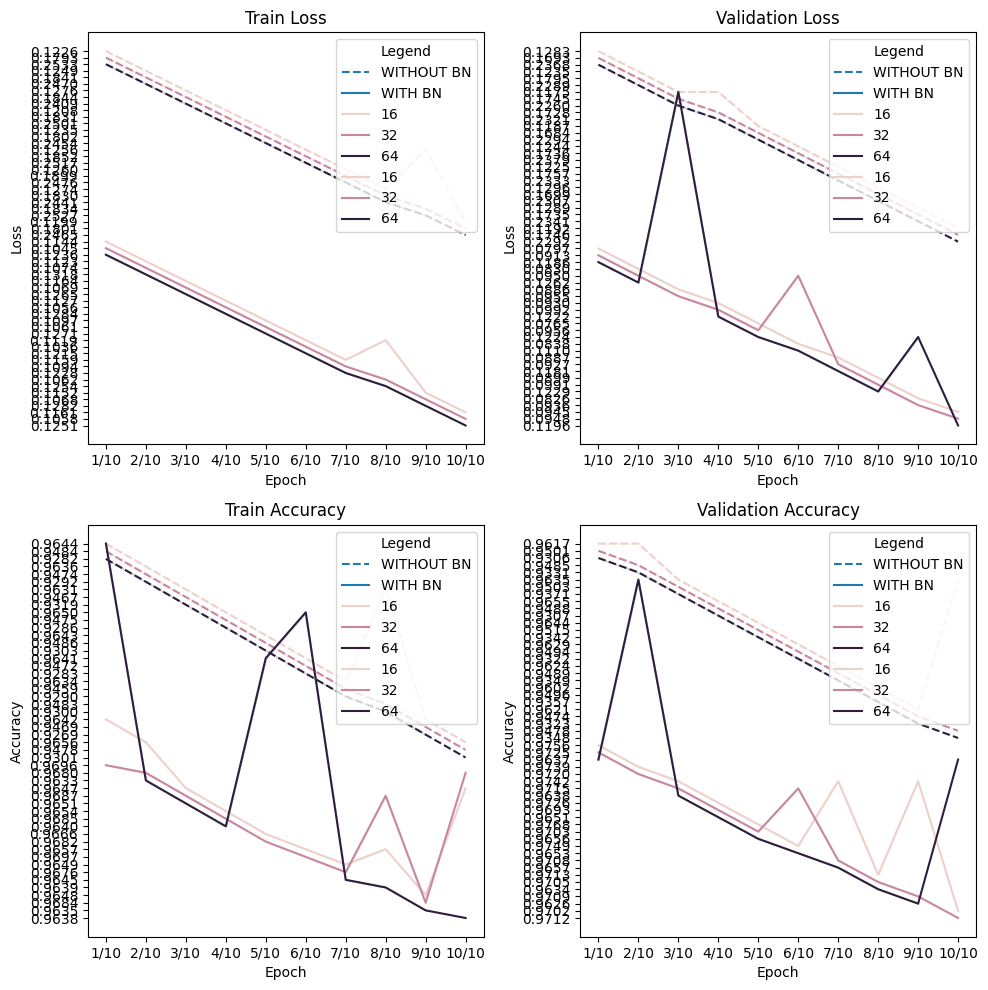

,Epoch,Batch Size,Train Loss (WITHOUT BN),Train Loss (WITH BN),Validation Loss (WITHOUT BN),Validation Loss (WITH BN),Train Accuracy (WITHOUT BN),Train Accuracy (WITH BN),Validation Accuracy (WITHOUT BN),Validation Accuracy (WITH BN)
0,1/10,16,0.1226,0.1144,0.1283,0.0797,0.9644,0.9642,0.9617,0.9756
1,1/10,32,0.1793,0.1045,0.1693,0.0913,0.9484,0.9696,0.9501,0.9725
2,1/10,64,0.2533,0.1236,0.2368,0.1186,0.9282,0.9644,0.9306,0.9637
3,1/10,16,0.1226,0.1144,0.1283,0.0797,0.9644,0.9642,0.9617,0.9756
4,1/10,32,0.1793,0.1045,0.1693,0.0913,0.9484,0.9696,0.9501,0.9725


In [2]:
import pandas            as pd
import seaborn           as sb
import matplotlib.pyplot as pt
from matplotlib.lines            import Line2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets   import mnist
from tensorflow.keras.models     import Sequential         as S
from tensorflow.keras.layers     import Dense              as D
from tensorflow.keras.layers     import BatchNormalization as BN


# Loading and processing the MNIST dataset
(x_train, y_train), (x_val, y_val) = mnist.load_data()
x_train           ,  x_val         = x_train/255            , x_val/255
x_train           ,  x_val         = x_train.reshape(-1,784), x_val.reshape(-1,784)

batch_sizes = [16, 32, 64]  # Define different batch sizes
epochs      = 10
results     = []
rows        = []
for e in range(epochs):
    for bs in batch_sizes:
        # m1 is model WITHOUT BN    &    m2 is model WITH BN
        m1 = S([D(128, activation='relu', input_shape=(784,))      , D(64, activation='relu')      , D(10, activation='softmax')])
        m2 = S([D(128, activation='relu', input_shape=(784,)), BN(), D(64, activation='relu'), BN(), D(10, activation='softmax')])
        m1.compile(optimizer=SGD(learning_rate=0.01), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        m2.compile(optimizer=SGD(learning_rate=0.01), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        h1 = m1.fit(x_train, y_train, epochs=5, batch_size=bs, validation_data=(x_val, y_val), verbose=0)
        h2 = m2.fit(x_train, y_train, epochs=5, batch_size=bs, validation_data=(x_val, y_val), verbose=0)

        row = [f"{e+1}/{epochs}"                      , bs,
               f"{h1.history['loss'][-1]:.4f}"        , f"{h2.history['loss'][-1]:.4f}",
               f"{h1.history['val_loss'][-1]:.4f}"    , f"{h2.history['val_loss'][-1]:.4f}",
               f"{h1.history['accuracy'][-1]:.4f}"    , f"{h2.history['accuracy'][-1]:.4f}",
               f"{h1.history['val_accuracy'][-1]:.4f}", f"{h2.history['val_accuracy'][-1]:.4f}"]
        rows.append(row)
    results.extend(rows)
    
# Create a DataFrame
header = ["Epoch"                           ,"Batch Size",
          "Train Loss (WITHOUT BN)"         , "Train Loss (WITH BN)",
          "Validation Loss (WITHOUT BN)"    , "Validation Loss (WITH BN)",
          "Train Accuracy (WITHOUT BN)"     , "Train Accuracy (WITH BN)",
          "Validation Accuracy (WITHOUT BN)", "Validation Accuracy (WITH BN)"]
df = pd.DataFrame(results, columns= header)

# For Visualizing the DataFrame
fig, ax = pt.subplots(2, 2, figsize=(10, 10))
sb.lineplot(data=df, x='Epoch', y='Train Loss (WITHOUT BN)'         , hue='Batch Size', ax=ax[0,0], linestyle='--')
sb.lineplot(data=df, x='Epoch', y='Train Loss (WITH BN)'            , hue='Batch Size', ax=ax[0,0])
sb.lineplot(data=df, x='Epoch', y='Validation Loss (WITHOUT BN)'    , hue='Batch Size', ax=ax[0,1], linestyle='--')
sb.lineplot(data=df, x='Epoch', y='Validation Loss (WITH BN)'       , hue='Batch Size', ax=ax[0,1])
sb.lineplot(data=df, x='Epoch', y='Train Accuracy (WITHOUT BN)'     , hue='Batch Size', ax=ax[1,0], linestyle='--')
sb.lineplot(data=df, x='Epoch', y='Train Accuracy (WITH BN)'        , hue='Batch Size', ax=ax[1,0])
sb.lineplot(data=df, x='Epoch', y='Validation Accuracy (WITHOUT BN)', hue='Batch Size', ax=ax[1,1], linestyle='--')
sb.lineplot(data=df, x='Epoch', y='Validation Accuracy (WITH BN)'   , hue='Batch Size', ax=ax[1,1])

ax[0,0].set(title='Train Loss'         , xlabel='Epoch', ylabel='Loss')
ax[0,1].set(title='Validation Loss'    , xlabel='Epoch', ylabel='Loss')
ax[1,0].set(title='Train Accuracy'     , xlabel='Epoch', ylabel='Accuracy')
ax[1,1].set(title='Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')

ls = [Line2D([0],[0], linestyle='--', label='WITHOUT BN'), Line2D([0],[0], linestyle='-', label='WITH BN')] 
ax[0,0].legend(handles=ls + ax[0,0].get_legend().legendHandles, title='Legend')
ax[0,1].legend(handles=ls + ax[0,1].get_legend().legendHandles, title='Legend')
ax[1,0].legend(handles=ls + ax[1,0].get_legend().legendHandles, title='Legend')
ax[1,1].legend(handles=ls + ax[1,1].get_legend().legendHandles, title='Legend')

pt.tight_layout()
pt.show()
df.head()

#### Discuss the advantages and potential limitations of batch normalization in improving the training of neural networks.
* **Advantages:**
    * Faster convergence.
    * Improved stability during training.
    * Reduced overfitting.
    * Effective training of very deep networks.
    * Robustness to weight initialization.
* **Limitations:**
    * Increased memory usage.
    * Mini-batch dependency.
    * Incompatibility with certain architectures.
    * Test-time statistics may not accurately represent individual examples.
    * Implementation complexity, especially in custom architectures.